### Notebook structure

- **Instructions** : set of important informations to understand the structure of the code and how to make it work.
- **Excercise 10.1** : Just a description of how the code was implemented to be parelellized.
- **Excercise 10.2** : Application of the TSP parallelized algorithm on the american capitals.

In [1]:
# fundamental packages
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from statistics import mode

sns.set_theme(style='whitegrid',palette='bright')


# Instructions

Intruction to C++ compilation and executions .

- To compile the code run in the directory 'es_10.2' the command :  `make`. 
- To automatically execute the code run :  `make run`. The code will be parallelized in 4 processes.
- To clear the files `.o` and the executable please run `make clean`.
- The input parameters are passed through the file `input.in`, right now the parameters are set to:


In [2]:
params = np.loadtxt("es_10.2/input.in", comments='#')
N_pop = params[0]
N_epoch = params[1]
N_migr = params[2]
N_send = params[3]

print("Number of chromosomes in a population:  \t",int(N_pop))
print("Number of time we evolved the population:\t",int(N_epoch))
print("N_send:  \t",int(N_send))
print("N_migr:  \t",int(N_migr))
print("Number of migration performed: \t",int(N_epoch/N_migr-1))


Number of chromosomes in a population:  	 1000
Number of time we evolved the population:	 500
N_send:  	 20
N_migr:  	 23
Number of migration performed: 	 20


- If executed, the program will store the output data in the directory `output/{number of performed migrations}_mig`. While running, the program will suggest to create the directory if it doesn't exist yet, make sure to do it if you change the input data.

# Excercise 10.01

In this exercise, I parallelized the algorithm developed in Exercise 9 using the MPI library. The approach involves a single main program executed by multiple processes in parallel, with each process working on a different dataset.

Simple parallelization increases the number of simultaneous simulations, but without communication between these processes, there is no way to collectively accelerate the simulation. This is why, every `N_migr` generations, I implemented a migration: the `N_send` best chromosomes from each process were collected and redistributed randomly among all processes, replacing the worst chromosomes. In genetic algorithm terminology, these parallel processes are often referred to as "continents" because they host populations that evolve independently and only occasionally come into contact to exchange genetic material.

For the functions developed in Exercise 9, I made adjustments to the initialization of the random number generator so that each process would have a different seed, generating distinct sequences of random numbers for each continent. In particular, I implemented a class for the genetic algorithm that uses the random number generator from the Armadillo library, for the different processes i set different seeds. 

# Excercise 10.02
In this excercise I used the parallelized code to apply the TSP problem to the 50 american capitals. The parameters chosen for the GA are the following (from the input file "input.in") 

In [6]:
params = np.loadtxt("es_10.2/input.in", comments='#')
N_pop = params[0]
N_epoch = params[1]

print("Number of chromosomes in a population:  \t",int(N_pop))
print("Number of time we evolved the population:\t",int(N_epoch))


Number of chromosomes in a population:  	 1000
Number of time we evolved the population:	 500


For this application I considered 4 processes:
- First I'll show what would be the optimized path with these parameters if all 4 th GA searches are indipendent, so there is no migration of informations.

/tmp/ipykernel_31406/1330419946.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


/tmp/ipykernel_31406/1330419946.py:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


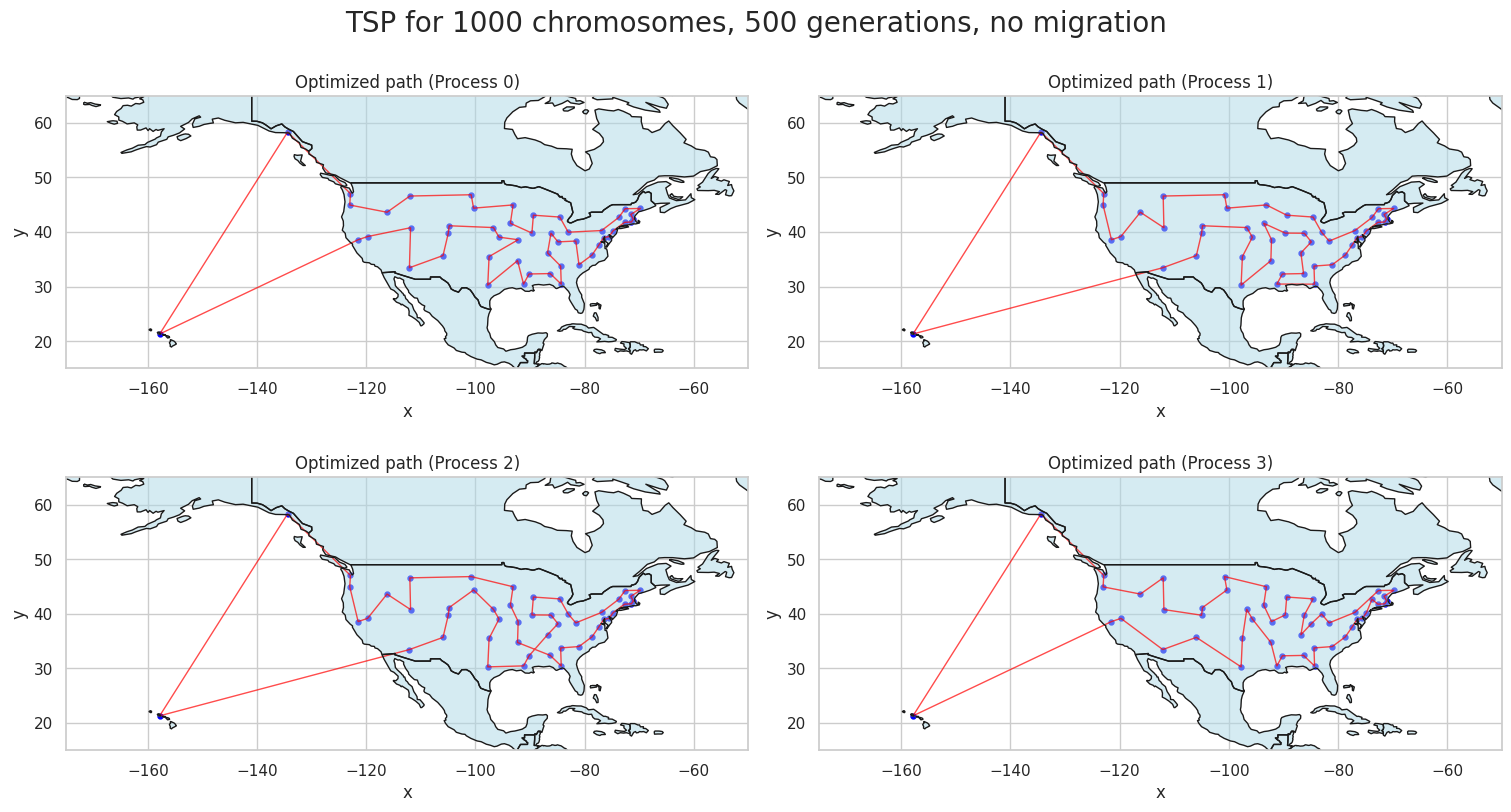

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load data from the file, skipping the first row and selecting the specified columns
x, y = np.loadtxt("es_10.2/American_capitals.dat", unpack=True)

# Create a GeoPandas GeoDataFrame with a single polygon representing a filled area
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
filled_area = gpd.GeoDataFrame({'geometry': [world.unary_union]})

# Set the fill color
fill_color = 'lightblue'

# Create a 2x2 grid of subplots for the four processes
fig, ax = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=True)

for i, ax_subplot in enumerate(ax.flat):
    best_path = np.loadtxt(
        f"es_10.2/output/0_migr/best_path_{i}.dat", dtype=int, unpack=True)
    x_best, y_best = x[best_path - 1], y[best_path - 1]
    x_best = np.append(x_best, x_best[0])
    y_best = np.append(y_best, y_best[0])

    ax_subplot.plot(x_best, y_best, color="red",lw=1,alpha=0.7)
    ax_subplot.scatter(x, y, color='blue', marker='.', s=50,alpha=1)

    world.boundary.plot(ax=ax_subplot, color='k', linewidth=1.0)
    filled_area.plot(ax=ax_subplot, color=fill_color, alpha=0.5)

    ax_subplot.set_xlim(-175, -50)
    ax_subplot.set_ylim(15, 65)

    ax_subplot.set_title(f"Optimized path (Process {i})", fontsize=12)
    ax_subplot.set_xlabel("x")
    ax_subplot.set_ylabel("y")
fig.suptitle(f"TSP for {int(N_pop)} chromosomes, {int(N_epoch)} generations, no migration" , fontsize=20)
fig.subplots_adjust(hspace=0)
# Display the plots
plt.show()


- Then I'll show what is the best result for the same search if a migration is performed between processes with the following parameters

In [9]:
params = np.loadtxt("es_10.2/input.in", comments='#')
N_epoch = params[1]
N_migr = params[2]
N_send = params[3]

print("N_send:  \t",int(N_send))
print("N_migr:  \t",int(N_migr))
print("Number of migration performed: \t",int(N_epoch/N_migr-1))

N_send:  	 20
N_migr:  	 23
Number of migration performed: 	 20


/tmp/ipykernel_31406/484187850.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


/tmp/ipykernel_31406/484187850.py:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


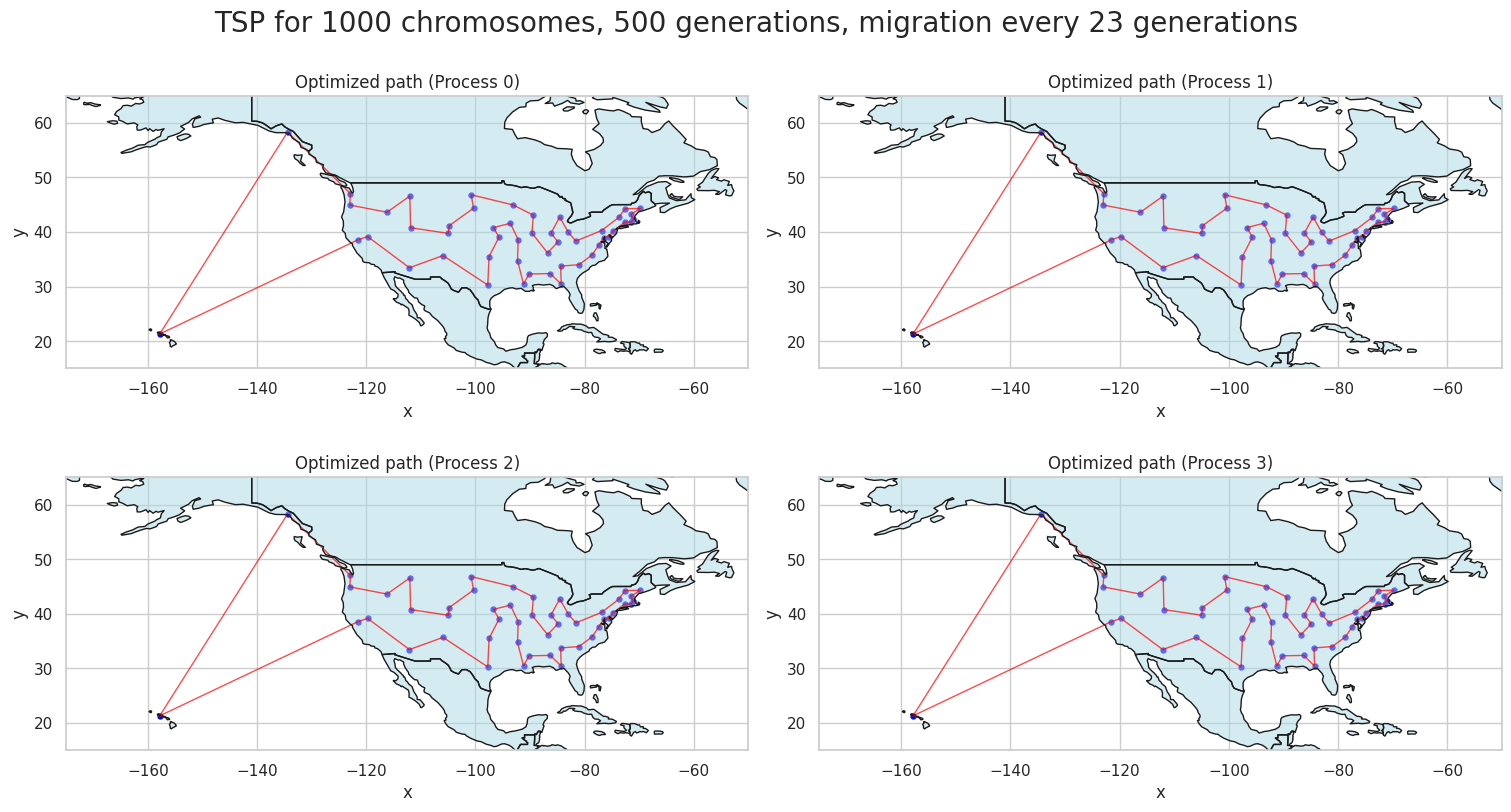

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load data from the file, skipping the first row and selecting the specified columns
x, y = np.loadtxt("es_10.2/American_capitals.dat", unpack=True)

# Create a GeoPandas GeoDataFrame with a single polygon representing a filled area
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
filled_area = gpd.GeoDataFrame({'geometry': [world.unary_union]})

# Set the fill color
fill_color = 'lightblue'

# Create a 2x2 grid of subplots for the four processes
fig, ax = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=True)

for i, ax_subplot in enumerate(ax.flat):
    best_path = np.loadtxt(
        f"es_10.2/output/20_migr/best_path_{i}.dat", dtype=int, unpack=True)   
    x_best, y_best = x[best_path - 1], y[best_path - 1]
    x_best = np.append(x_best, x_best[0])
    y_best = np.append(y_best, y_best[0])

    ax_subplot.plot(x_best, y_best, color="red",lw=1,alpha=0.7)
    ax_subplot.scatter(x, y, color='blue', marker='.', s=50,alpha=1)

    world.boundary.plot(ax=ax_subplot, color='k', linewidth=1.0)
    filled_area.plot(ax=ax_subplot, color=fill_color, alpha=0.5)

    ax_subplot.set_xlim(-175, -50)
    ax_subplot.set_ylim(15, 65)

    ax_subplot.set_title(f"Optimized path (Process {i})", fontsize=12)
    ax_subplot.set_xlabel("x")
    ax_subplot.set_ylabel("y")
fig.suptitle(f"TSP for {int(N_pop)} chromosomes, {int(N_epoch)} generations, migration every {int(N_migr)} generations" ,fontsize=20)
fig.subplots_adjust(hspace=0)
# Display the plots
plt.show()


As one might anticipate, when multiple processes collaborate and share information, they tend to converge on a common result as they work together to find the optimal solution, whereas the four outcomes of independent searches vary. While this consistency can provide a sense of reassurance, it alone is insufficient to assess the enhancement of the optimization algorithm. To gain a deeper understanding of the effectiveness of the parallelization, it is essential to analyze how the cost function behaves in various scenarios.

### Cost 

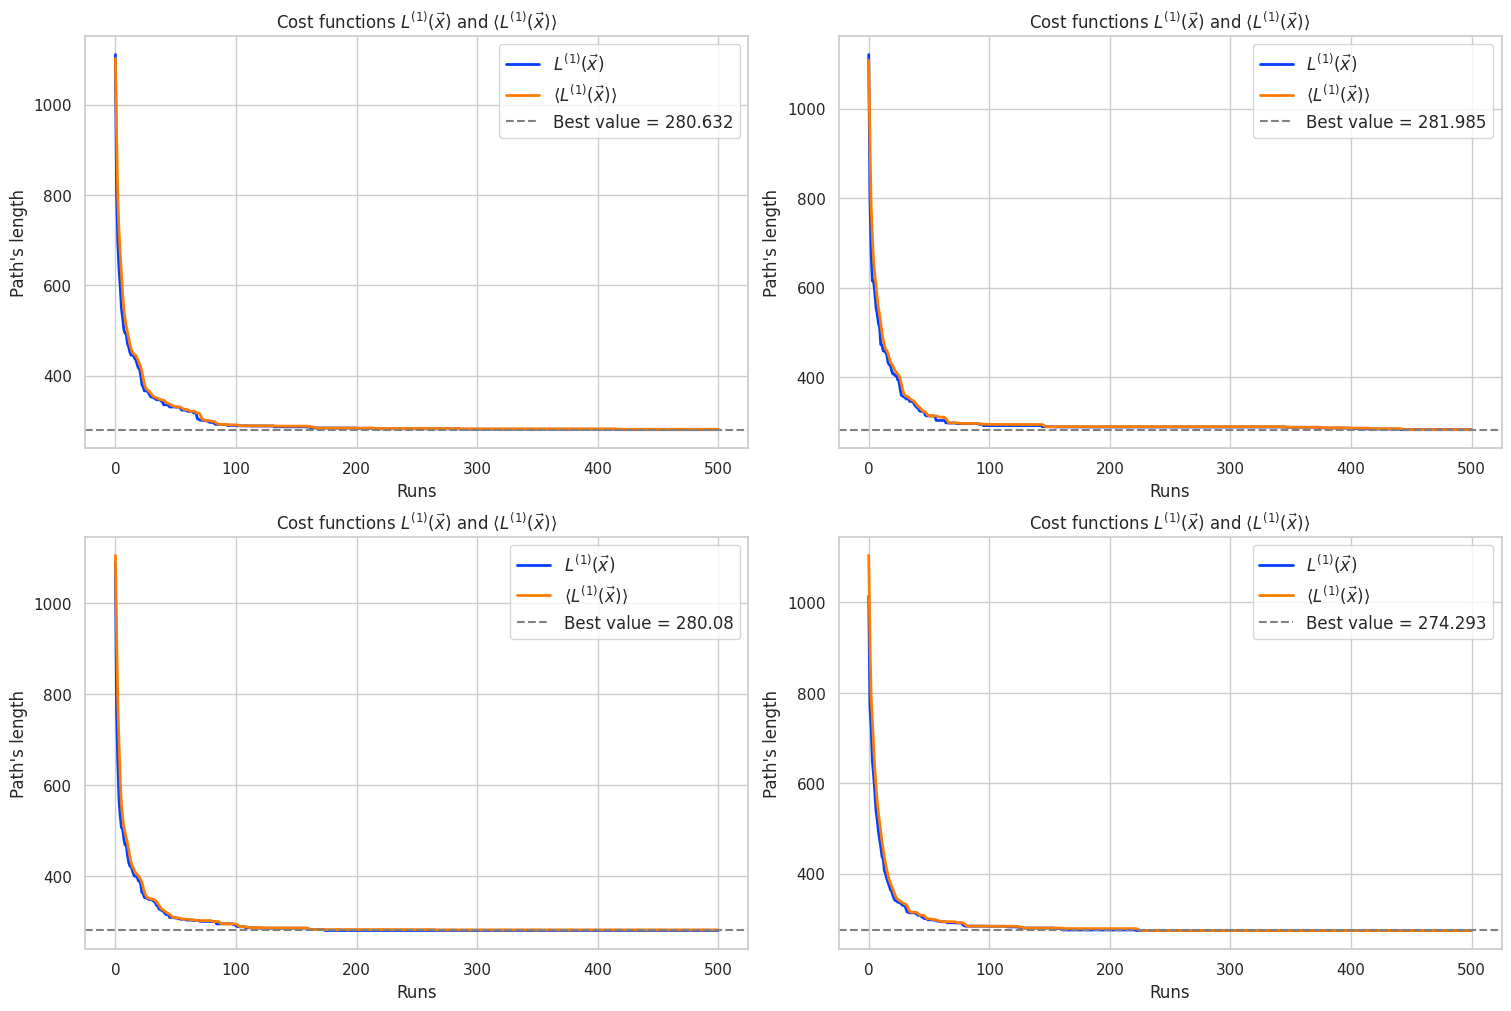

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots for the four processes
fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

for i in range(2):
    for j in range(2):
        cost, avg_cost = np.loadtxt(
            f"es_10.2/output/0_migr/cost_{i*2+j}_rank.txt", dtype=float, unpack=True, skiprows=1)
        ax[i, j].plot(np.arange(len(cost)), cost,
                      label=r"$L^{(1)}(\vec x)$",lw=2)
        ax[i, j].plot(np.arange(len(avg_cost)), avg_cost,
                      label=r"$\langle L^{(1)}(\vec x) \rangle$",lw=2)
        ax[i, j].set_title(
            r"Cost functions $L^{(1)}(\vec x)$ and $\langle L^{(1)}(\vec x) \rangle$", fontsize=12)
        ax[i, j].axhline(cost.min(),color='grey',linestyle='--',label=f"Best value = {cost.min()}")
        ax[i, j].legend(loc="best" ,prop={'size': 12})
        ax[i, j].set_xlabel("Runs")
        ax[i, j].set_ylabel("Path's length")

plt.show()


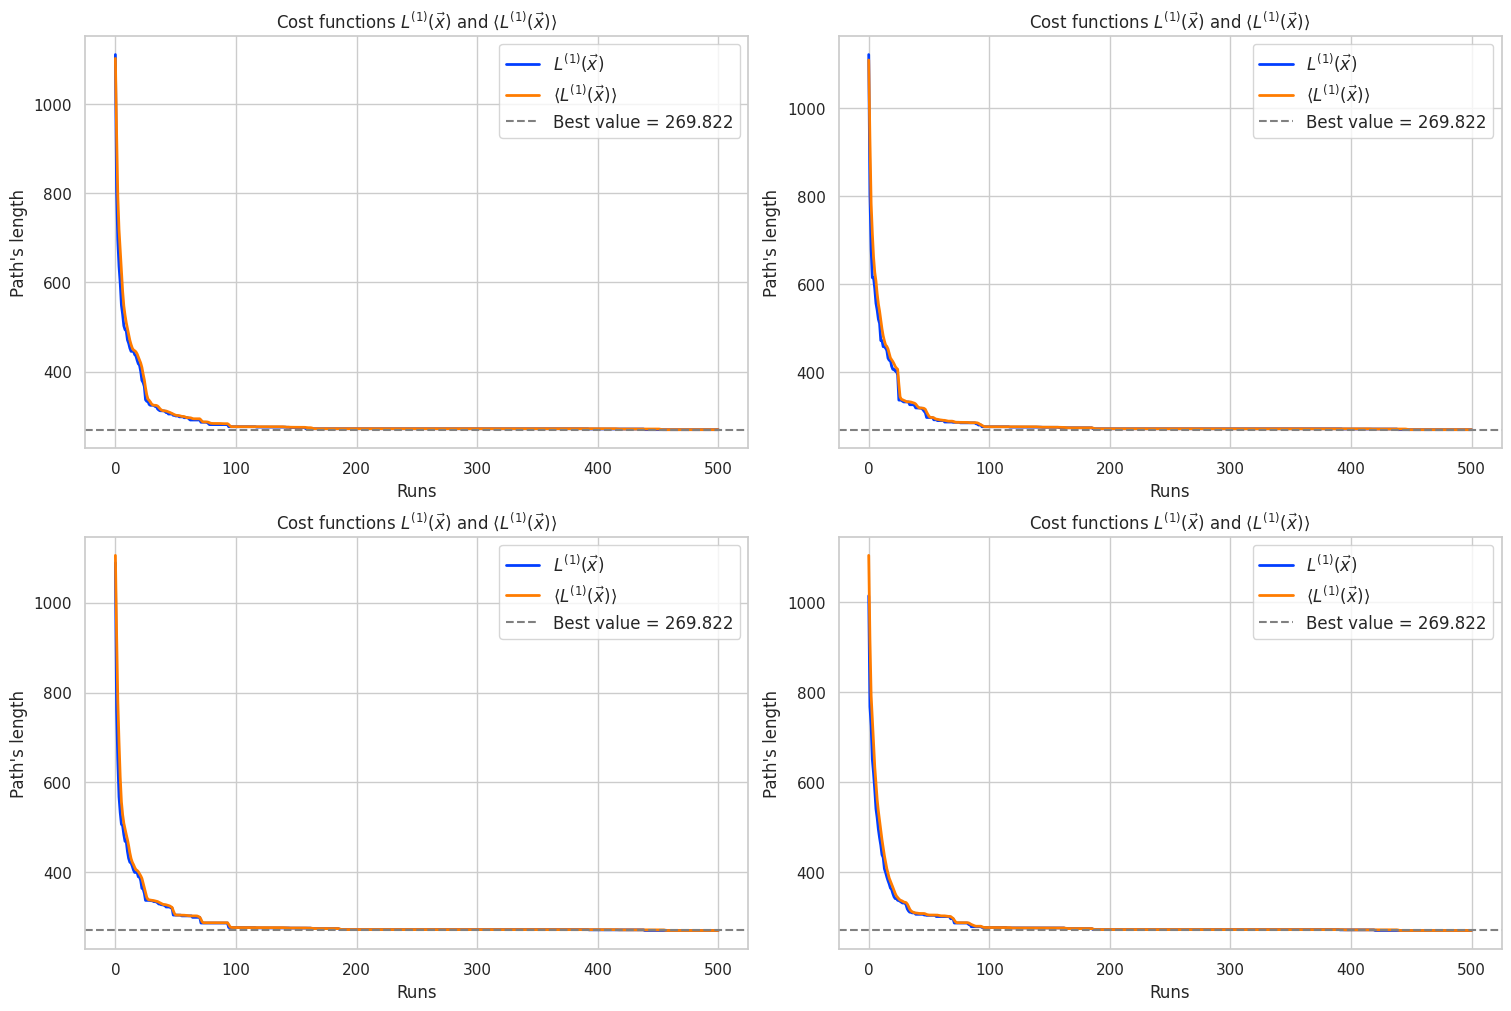

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots for the four processes
fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

for i in range(2):
    for j in range(2):
        cost, avg_cost = np.loadtxt(
            f"es_10.2/output/20_migr/cost_{i*2+j}_rank.txt", dtype=float, unpack=True, skiprows=1)
        ax[i, j].plot(np.arange(len(cost)), cost,
                      label=r"$L^{(1)}(\vec x)$", lw=2)
        ax[i, j].plot(np.arange(len(avg_cost)), avg_cost,
                      label=r"$\langle L^{(1)}(\vec x) \rangle$", lw=2)
        ax[i, j].set_title(
            r"Cost functions $L^{(1)}(\vec x)$ and $\langle L^{(1)}(\vec x) \rangle$", fontsize=12)
        ax[i, j].axhline(cost.min(), color='grey', linestyle='--', label=f"Best value = {cost.min()}")
        ax[i, j].legend(loc="best", prop={'size': 12})
        ax[i, j].set_xlabel("Runs")
        ax[i, j].set_ylabel("Path's length")
        ax[i, j].grid(True)  # Add grid lines

plt.show()


Analyzing the cost functio, we notice that the loss of variety is primarily due to the fact that migrations have led the four continents toward a significantly better solution compared to those obtained without migrations. The convergence speed remained almost identical to the case without migrations. This can be explained by realizing that the convergence time is primarily determined by the complexity of the problem and the initial configuration from which one starts. Migrations, on the other hand, seem to be more beneficial when one is already in configurations with good fitness, further improving it by a few points.